# Exemplo de parada antecipada (Early Stopping)
Neste notebook, treinaremos um Perceptron de Múltiplas Camadas (MLP) para classificar imagens do banco de dados de dígitos manuscritos [MNIST database] (http://yann.lecun.com/exdb/mnist/) e usaremos a parada antecipada para interromper o treinamento quando o modelo começar a se ajustar demais aos dados de treinamento.

In [1]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
print("GPU available: {}".format(torch.cuda.is_available()))
device = 'cuda' #'cpu' if no GPU available

GPU available: True


### Load and Batch the Data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#Função handle para cirar datasets padrões do Pytorch

def create_datasets(batch_size):

    # porcentagem para validação do conjunto
    valid_size = 0.2

    # convertendo os dados para tensores
    transform = transforms.ToTensor()

    # dividindo
    train_data = datasets.MNIST(root='mnist', 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root='mnist',
                               train=False,
                               download=True,
                               transform=transform)

    # obtendo os indices de treino com o numero de dados.
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices) #randomizar os indices para treino é uma boa pratica
    split = int(np.floor(valid_size * num_train)) #arredondando o valor de 20% do dataset para o inteiro mais próximo
    train_idx, valid_idx = indices[split:], indices[:split] #dividindo de fato.
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

### Definir a rede
Definição de um modelo MLP simples.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # adicionar camada oculta, com função de ativação relu
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # adicionar camada oculta, com função de ativação relu
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
model.to(device)
print(model) 

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Especifique a função de perda e o otimizador

In [4]:
# especificar a função de perda
criterion = nn.CrossEntropyLoss()

# especificar o otimizador
optimizer = torch.optim.Adam(model.parameters())

### Importar a classe Early Stopping Class

pip install early-stopping-pytorch

In [5]:
# import EarlyStopping
from early_stopping_pytorch import EarlyStopping

### Train the Model using Early Stopping

In [13]:
def train_model(model, batch_size, patience, n_epochs):
    
    # para rastrear a perda de treinamento à medida que o modelo é treinado
    train_losses = []
    # para rastrear a perda de validação à medida que o modelo é treinado
    valid_losses = []
    # para rastrear a perda média de treinamento por época à medida que o modelo é treinado
    avg_train_losses = []
    # para rastrear a perda média de validação por época à medida que o modelo é treinado
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # preparando para treino
        for batch, (data, target) in enumerate(train_loader, 1):

            # limpeza de gradientes
            optimizer.zero_grad()

            # forward pass: calcula as saídas previstas passando as entradas para o modelo
            output = model(data.to(device))
           
            loss = criterion(output, target.to(device))
            # back propagation: calcular o gradiente da perda com relação aos parâmetros do modelo
            loss.backward()
            # executar uma única etapa de otimização (atualização de parâmetros)
            optimizer.step()
            # registro de perda de treinamento
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # preparar o modelo para avaliação
        for data, target in valid_loader:

            #forward
            output = model(data.to(device))
            # calcula a loss
            loss = criterion(output, target.to(device))
            # armazena a loss
            valid_losses.append(loss.item())

        # print training/validation 
        # Calcula a média por cada época
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        #limpar a lista de loss a cada época
        train_losses = []
        valid_losses = []
        
        # O early_stopping precisa da perda de validação para verificar se ela diminuiu, 
        # e, se tiver, ele fará um ponto de verificação do modelo atual
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # Carregar o último ponto de verificação com o melhor modelo
    model.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

    return  model, avg_train_losses, avg_valid_losses

In [14]:
batch_size = 256
n_epochs = 100

train_loader, test_loader, valid_loader = create_datasets(batch_size)

# early stopping patience; quanto tempo esperar após a última vez que a perda de validação melhorou.
patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

[  1/100] train_loss: 0.83483 valid_loss: 0.30336
Validation loss decreased (inf --> 0.303357).  Saving model ...
[  2/100] train_loss: 0.37458 valid_loss: 0.22665
Validation loss decreased (0.303357 --> 0.226650).  Saving model ...
[  3/100] train_loss: 0.30068 valid_loss: 0.18680
Validation loss decreased (0.226650 --> 0.186804).  Saving model ...
[  4/100] train_loss: 0.26050 valid_loss: 0.16314
Validation loss decreased (0.186804 --> 0.163136).  Saving model ...
[  5/100] train_loss: 0.23453 valid_loss: 0.15279
Validation loss decreased (0.163136 --> 0.152790).  Saving model ...
[  6/100] train_loss: 0.21679 valid_loss: 0.14054
Validation loss decreased (0.152790 --> 0.140538).  Saving model ...
[  7/100] train_loss: 0.20016 valid_loss: 0.13738
Validation loss decreased (0.140538 --> 0.137379).  Saving model ...
[  8/100] train_loss: 0.18956 valid_loss: 0.12783
Validation loss decreased (0.137379 --> 0.127830).  Saving model ...
[  9/100] train_loss: 0.17919 valid_loss: 0.11828
Val

### Visualizando a perda e o ponto de verificação de parada antecipada
No gráfico, podemos ver que o último ponto de verificação de parada antecipada foi salvo logo antes de o modelo começar a se ajustar demais.

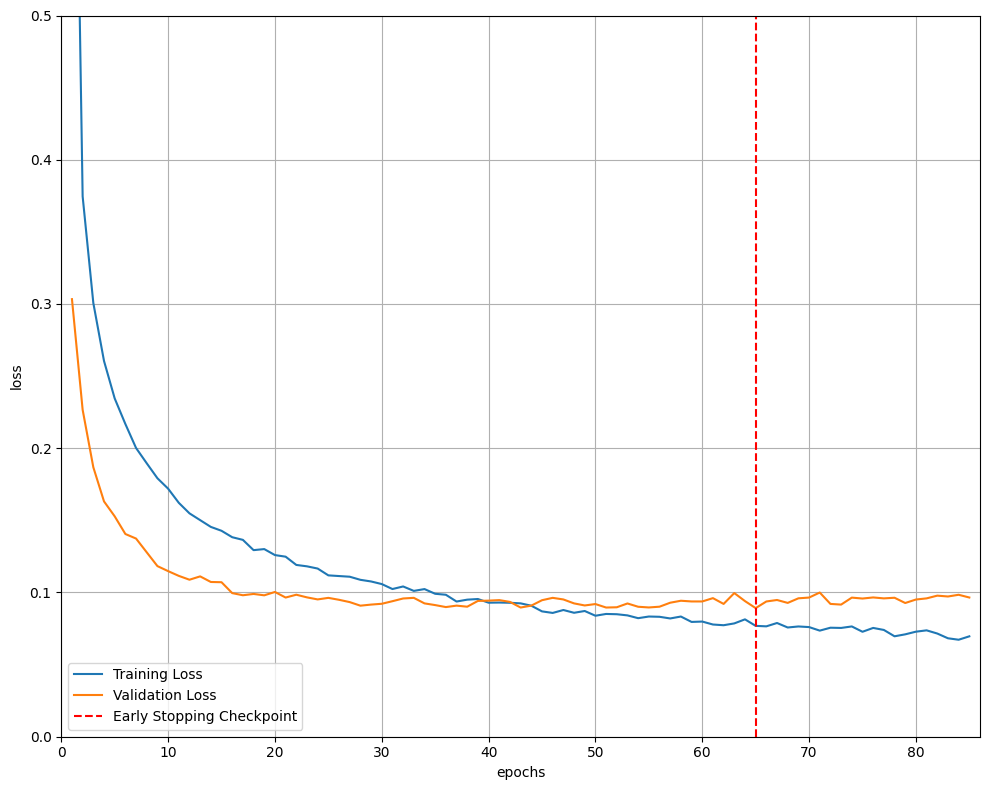

In [15]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

### Test the Trained Network

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

### Visualize Sample Test Results

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 // 2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))


## References

The MNIST training example code is mainly taken from the [mnist_mlp_solution_with_validation.ipynb](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution_with_validation.ipynb) notebook from the [deep-learning-v2-pytorch repository](https://github.com/udacity/deep-learning-v2-pytorch) made by [Udacity](https://www.udacity.com/), and has been fitted with my early stopping code. 